In [1]:
# --- Автоперезагрузка модулей ---
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import argparse

pd.set_option('display.float_format', '{:.2f}'.format) ## 2 знака после запятой

In [5]:
from raw_data import RawData
from filtered_data import FilteredData
from raw_data_filter import RawDataFilter
from calibration_data import CalibrationData
from calibration_processor import CalibrationProcessor

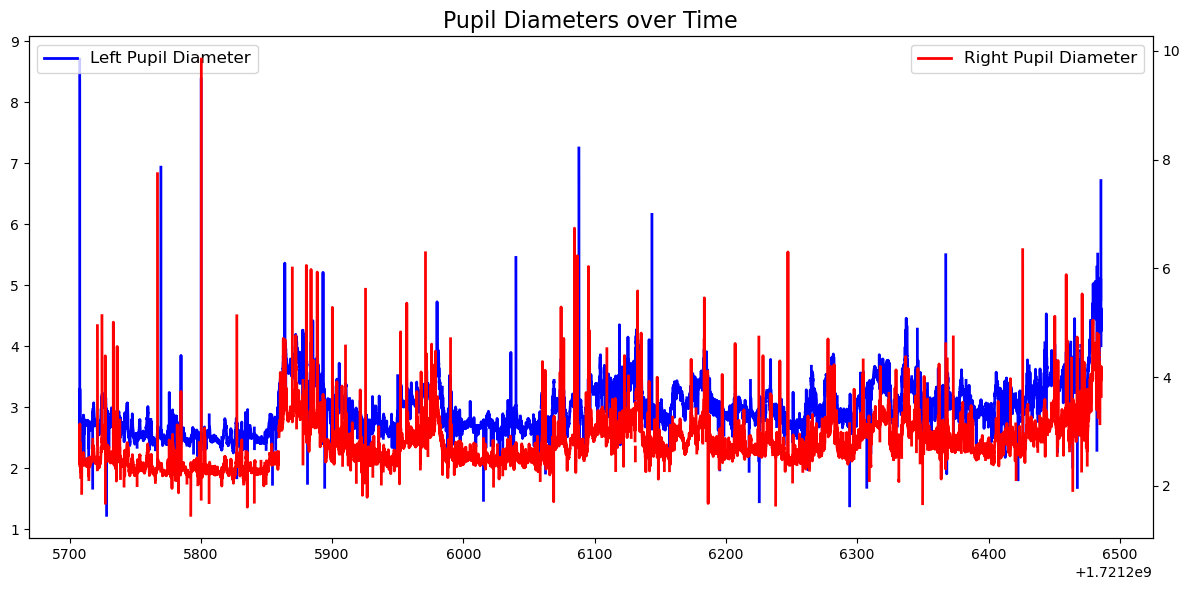

In [31]:
# =============================================================================
# 1. Рабочая директория
# =============================================================================
work_dir = Path.cwd()
input_dir = work_dir / 'input'  # Теперь все данные ищем в папке input

# =============================================================================
# 2. Пути к файлам
# =============================================================================
gz_path = input_dir / '825.gz'

# =============================================================================
# 3. Инициализация RawData
# =============================================================================
if 'fRawData' in locals():
    del fRawData
fRawData = RawData(str(gz_path), user_id=825)

# =============================================================================
# 4. Визуализация сырых данных
# =============================================================================
raw_data = fRawData.get_raw_data()

# Проверка наличия необходимых столбцов
required_cols = [
    'data.eyeleft.pupildiameter',
    'data.eyeright.pupildiameter'
]
if not all(col in raw_data.columns for col in required_cols):
    raise ValueError(
        f"В данных отсутствует хотя бы один из столбцов: {required_cols}"
    )

fig, ax1 = plt.subplots(figsize=(12, 6))

# — График для левого зрачка
ax1.plot(
    raw_data['timestamp'],
    raw_data['data.eyeleft.pupildiameter'],
    color='blue',                     # <- явно задаём синий
    label='Left Pupil Diameter',
    linewidth=2
)

# — График для правого зрачка (twinx)
ax2 = ax1.twinx()
ax2.plot(
    raw_data['timestamp'],
    raw_data['data.eyeright.pupildiameter'],
    color='red',                      # <- явно задаём красный
    label='Right Pupil Diameter',
    linewidth=2
)

# Заголовок и легенды
plt.title('Pupil Diameters over Time', fontsize=16)
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

In [9]:
# =============================================================================
# 6. Применение степа фильтрования
# =============================================================================

fFilterData = FilteredData(raw_df=fRawData.get_raw_data(), user_id=fRawData.get_user_id())

# Фильтрация
RawDataFilter.filter_missing_data(fFilterData)             # filter by missing data: 
RawDataFilter.filter_only_gaze(fFilterData)               # filter by only gaze events
RawDataFilter.filter_by_timestamp(fFilterData, '01/01/2022')  # filter by timestamp: 
RawDataFilter.filter_invalid_pupils(fFilterData, min_size=1.0, max_size=10.0)  # filter by invalid pupil size
RawDataFilter.filter_unrealistic_event_spacing(fFilterData, 0.005)  # filter by unrealistic event spacing
RawDataFilter.filter_async_pupil_size(fFilterData, 0.02)   # filter by asynchronous pupil changes
RawDataFilter.filter_pupil_speed(fFilterData, max_speed_mm_per_sec=5.0)  # filter by pupil speed
RawDataFilter.filter_constant_pupil(fFilterData, 100, 0.001)  # filter by constant pupil segments
RawDataFilter.filter_by_std_outliers(fFilterData, time_window=0.5, sigma_threshold=2)  # filter by std outliers

#Валидация TODO добавить методы внутрь класса
fFilterData.validate_filters()
# Теперь только достаём данные
df = fFilterData.get_data()

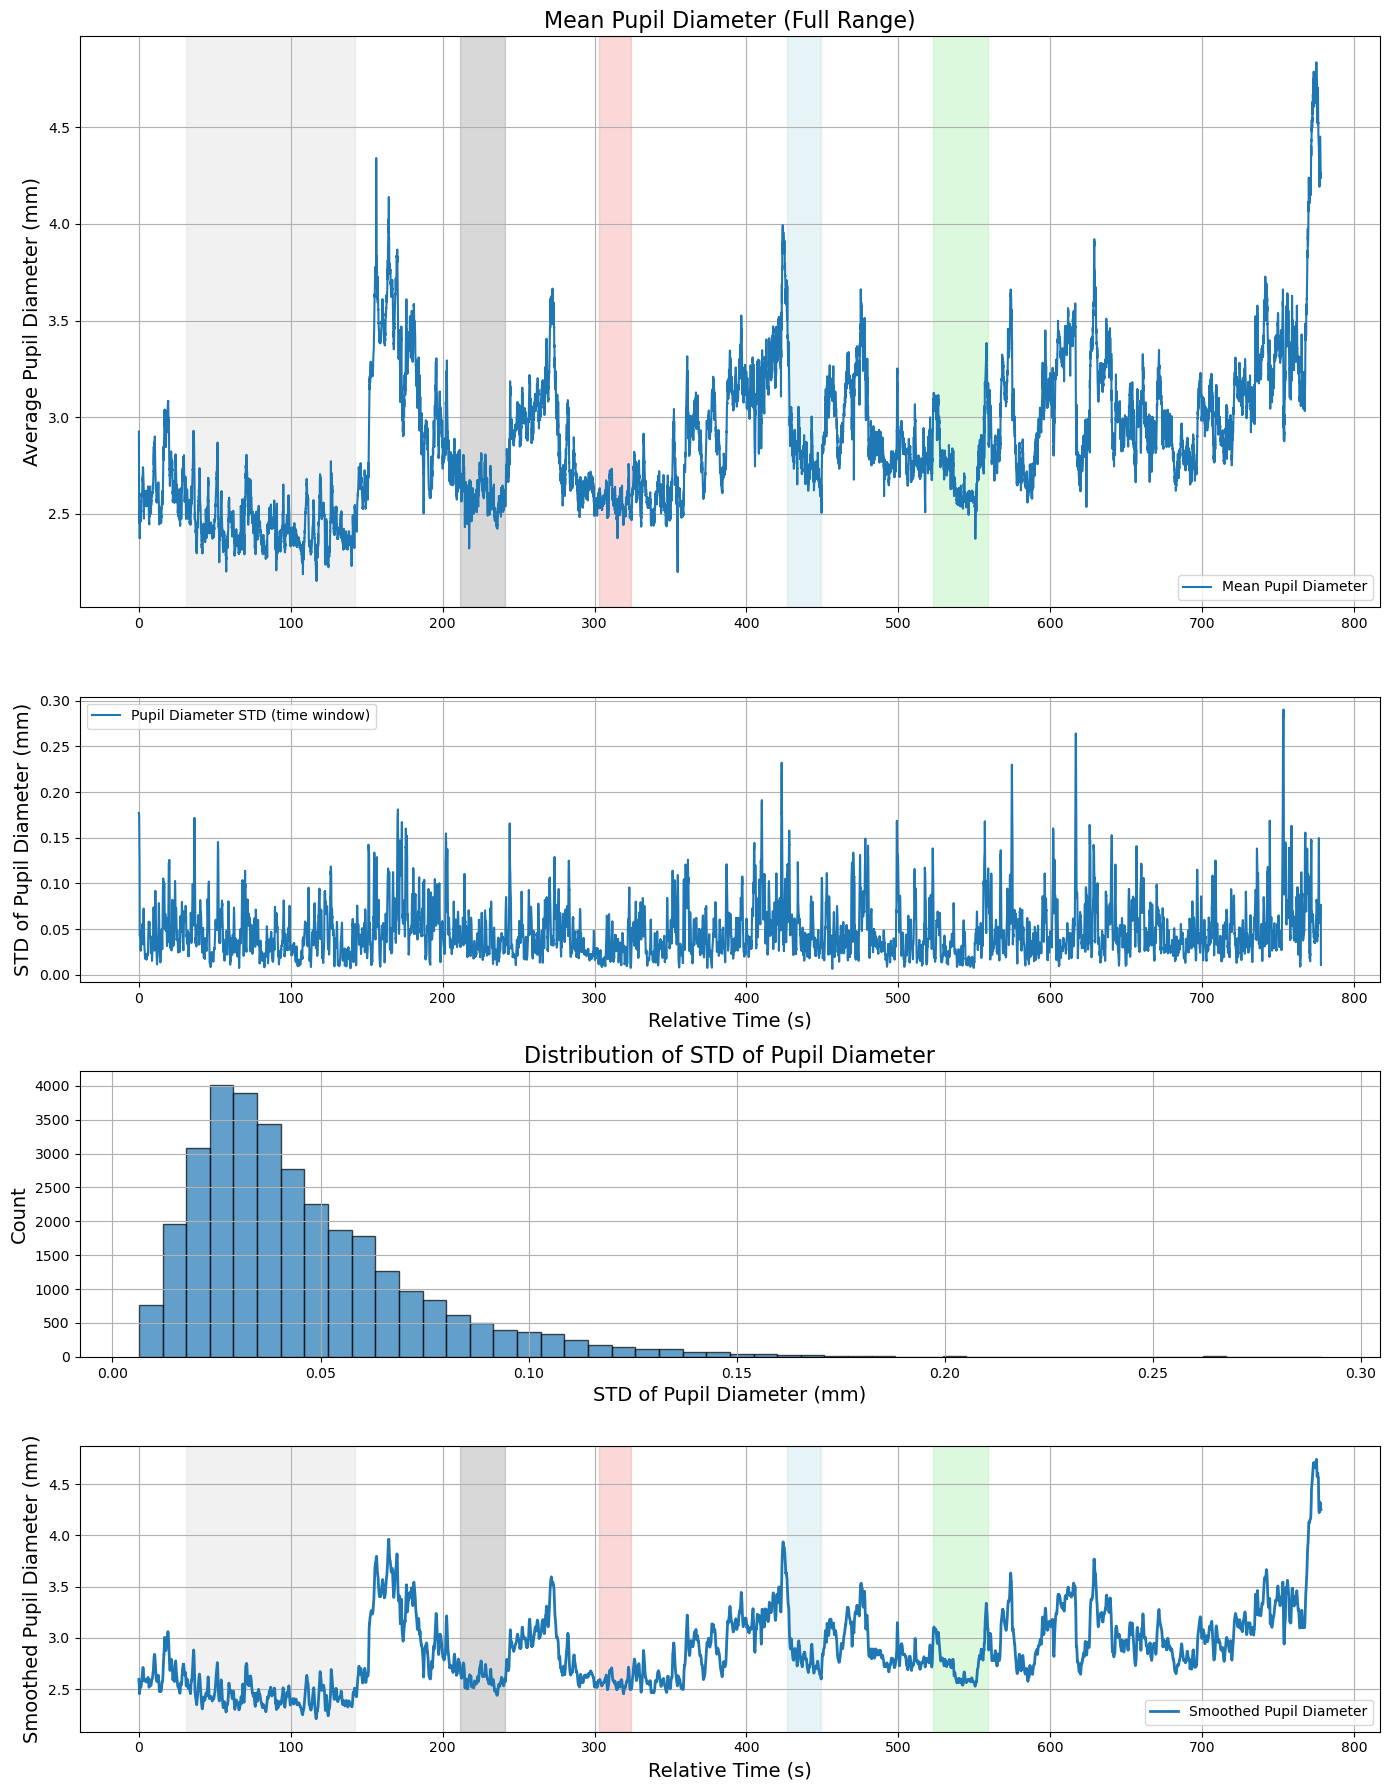

In [25]:
# =============================================================================
# Рисуем данные после фильтра
# =============================================================================

# 1) Оставляем только валидные строки
valid_data = df[df['is_valid']]

# 2) Опциональные ограничения по времени
start_time = None
end_time   = None

plot_data = valid_data.copy()
if start_time is not None and end_time is not None:
    plot_data = plot_data[
        (plot_data['relative_timestamp'] >= start_time) &
        (plot_data['relative_timestamp'] <= end_time)
    ]

# 3) Группируем для среднего
grouped_mean = plot_data.groupby('relative_timestamp')['avg_pupildiameter'].mean()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4, 1,
    figsize=(14, 18),
    gridspec_kw={'height_ratios': [2, 1, 1, 1]},
    sharex=False
)

phase_colors = {
    "Baseline":  "lightgrey",
    "Positive":  "lightgreen",
    "Neutral_2": "lightblue",
    "Negative":  "lightcoral",
}

# 6) Закрашиваем области фаз на первом и четвёртом графиках
for phase, (t0, t1) in time_ranges.items():
    color = phase_colors.get(phase, "grey")
    ax1.axvspan(t0, t1, color=color, alpha=0.3)
    ax4.axvspan(t0, t1, color=color, alpha=0.3)

# --- Первый график: среднее значение pupil diameter ---
ax1.plot(
    grouped_mean.index,
    grouped_mean.values,
    label='Mean Pupil Diameter'
)
ax1.set_ylabel('Average Pupil Diameter (mm)', fontsize=14)
ax1.legend()
ax1.grid(True)
if start_time is not None and end_time is not None:
    ax1.set_title(f'Mean Pupil Diameter ({start_time}-{end_time} s)', fontsize=16)
else:
    ax1.set_title('Mean Pupil Diameter (Full Range)', fontsize=16)

# --- Второй график: STD of pupil diameter в окне ±0.5 с ---
ax2.plot(
    plot_data['relative_timestamp'],
    plot_data['std_pupildiameter'],
    label='Pupil Diameter STD (time window)'
)
ax2.set_xlabel('Relative Time (s)', fontsize=14)
ax2.set_ylabel('STD of Pupil Diameter (mm)', fontsize=14)
ax2.legend()
ax2.grid(True)

# --- Третий график: гистограмма распределения std_pupildiameter ---
std_data = plot_data['std_pupildiameter'].dropna()
ax3.hist(
    std_data,
    bins=50,
    alpha=0.7,
    edgecolor='black'
)
ax3.set_xlabel('STD of Pupil Diameter (mm)', fontsize=14)
ax3.set_ylabel('Count', fontsize=14)
ax3.set_title('Distribution of STD of Pupil Diameter', fontsize=16)
ax3.grid(True)

# --- Четвёртый график: сглаженные значения avg_pupildiameter ---
ax4.plot(
    plot_data['relative_timestamp'],
    plot_data['avg_pupildiameter_smooth'],
    label='Smoothed Pupil Diameter',
    linewidth=2
)
ax4.set_xlabel('Relative Time (s)', fontsize=14)
ax4.set_ylabel('Smoothed Pupil Diameter (mm)', fontsize=14)
ax4.legend()
ax4.grid(True)

plt.tight_layout()
save_path = work_dir / 'figures' / 'std_analysis.png'
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(str(save_path), dpi=300, bbox_inches='tight')

plt.show()

In [13]:
# функция считывания json файла с временами тестирования

def load_time_ranges(file_path, user_id):
    with open(file_path, 'r', encoding='utf-8') as f:
        all_timings = json.load(f)

    if str(user_id) not in all_timings:
        raise ValueError(f"Нет данных для пользователя {user_id} в файле {file_path}")

    return {item['shelf']: item['time_range'] for item in all_timings[str(user_id)]}

In [21]:
# =============================================================================
# Процесс калибровки. Рассчёт baseline....
# =============================================================================


time_shifts_path = 'timings_by_shelf.json'  # Теперь все данные ищем в папке input
output_json_path  = "calibration_704.json"

time_ranges = load_time_ranges(str(time_shifts_path), fFilterData.get_user_id())
#print(time_ranges)

baseline_mean, baseline_std = CalibrationProcessor.compute_baseline(
    filtered_data=fFilterData,
    time_ranges=time_ranges
)

print(baseline_mean)
print(baseline_std)

2.4286616971194506
0.10299809290937495
